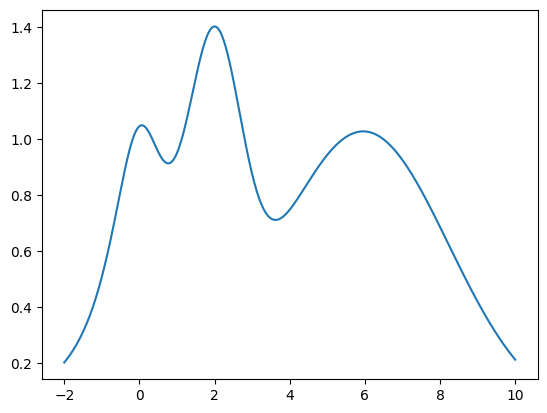

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

np.random.seed(42)
xs = np.linspace(-2, 10, 10000)

def f(x):
    return np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1/ (x ** 2 + 1)

plt.plot(xs, f(xs))
plt.show()

In [12]:
def plot_bo(f, bo):
    x = np.linspace(-2, 10, 10000)
    mean, sigma = bo._gp.predict(x.reshape(-1, 1), return_std=True)

    plt.figure(figsize=(16, 9))
    plt.plot(x, f(x))
    plt.plot(x, mean)
    plt.fill_between(x, mean + sigma, mean - sigma, alpha=0.1)
    plt.scatter(bo.space.params.flatten(), bo.space.target, c="red", s=50, zorder=10)
    plt.show()

Target and next point
0.6647088038254013 {'x': np.float64(-0.7284632634542514)}
[1.         0.98101528 0.99999757 ... 1.         0.99999834 0.93107916]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
Target and next point
0.26662084062699054 {'x': np.float64(9.690862262261966)}
[0.19904398 0.19904398 0.17109202 ... 0.19904398 0.19904398 0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
[0.19904398]
Target and next point
0.8428997452176735 {'x': np.float64(4.478097633655674)}
[0.24090649 0.24090649 0.24090649 ... 0.24090649 0.24090649 0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24090649]
[0.24

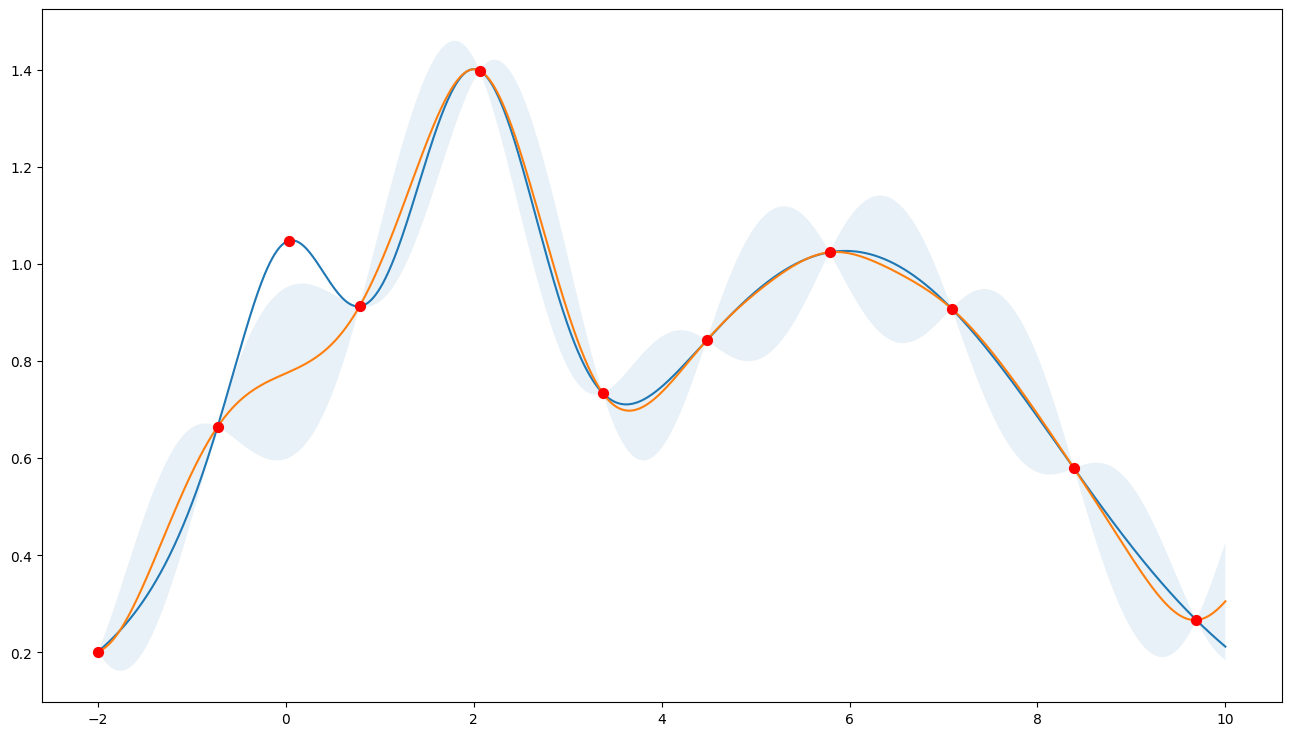

In [15]:
class EIG(acquisition.AcquisitionFunction):
    def __init__(
        self,
        noise_var = 0.1**2,
        random_state= None,
    ) -> None:
        self.noise_var = noise_var
        super().__init__(random_state=random_state)

    def base_acq(self, mean, std):
        acq = 0.5 * np.log(1 + (std**2) / self.noise_var)
        print(acq)
        return acq

    def suggest(
        self,
        gp,
        target_space,
        n_random: int = 10_000,
        n_smart: int = 10,
        fit_gp: bool = True,
        random_state = None,
    ) :
        if target_space.constraint is not None:
            msg = (
                f"Received constraints, but acquisition function {type(self)} "
                "does not support constrained optimization."
            )
            raise ConstraintNotSupportedError(msg)
        x_max = super().suggest(
            gp=gp,
            target_space=target_space,
            n_random=n_random,
            n_smart=n_smart,
            fit_gp=fit_gp,
            random_state=random_state,
        )
        return x_max

    def decay_exploration(self) -> None:
        """Decay kappa by a constant rate.

        Adjust exploration/exploitation trade-off by reducing kappa.

        Note
        ----

        This method is called automatically at the end of each ``suggest()`` call.
        """
        pass

    def get_acquisition_params(self) -> dict:
        """Get the current acquisition function parameters.

        Returns
        -------
        dict
            Dictionary containing the current acquisition function parameters.
        """
        return {"noise_var": self.noise_var}
        
    def set_acquisition_params(self, params: dict) -> None:
        """Set the acquisition function parameters.

        Parameters
        ----------
        params : dict
            Dictionary containing the acquisition function parameters.
        """
        self.noise_var = params["noise_var"]

acquisition_function = ModelVariance()

bo = BayesianOptimization(
    f=f,
    acquisition_function=acquisition_function,
    pbounds={"x": (-2, 10)},
    verbose=0,
    random_state=987234,
)

# bo.maximize(n_iter=1)
for _ in range(11):
    next_point = bo.suggest()
    target = f(**next_point)
    bo.register(params=next_point, target=target)
    print("Target and next point")
    print(target, next_point)

plot_bo(f, bo)